In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import warnings
warnings.filterwarnings("ignore")


In [ ]:
## Necessary Packages
import numpy as np
import tensorflow as tf


def train_test_divide (data_x, data_x_hat, data_t, data_t_hat, train_rate = 0.8):
  """Divide train and test data for both original and synthetic data.
  
  Args:
    - data_x: original data
    - data_x_hat: generated data
    - data_t: original time
    - data_t_hat: generated time
    - train_rate: ratio of training data from the original data
  """
  # Divide train/test index (original data)
  no = len(data_x)
  idx = np.random.permutation(no)
  train_idx = idx[:int(no*train_rate)]
  test_idx = idx[int(no*train_rate):]
    
  train_x = [data_x[i] for i in train_idx]
  test_x = [data_x[i] for i in test_idx]
  train_t = [data_t[i] for i in train_idx]
  test_t = [data_t[i] for i in test_idx]      
    
  # Divide train/test index (synthetic data)
  no = len(data_x_hat)
  idx = np.random.permutation(no)
  train_idx = idx[:int(no*train_rate)]
  test_idx = idx[int(no*train_rate):]
  
  train_x_hat = [data_x_hat[i] for i in train_idx]
  test_x_hat = [data_x_hat[i] for i in test_idx]
  train_t_hat = [data_t_hat[i] for i in train_idx]
  test_t_hat = [data_t_hat[i] for i in test_idx]
  
  return train_x, train_x_hat, test_x, test_x_hat, train_t, train_t_hat, test_t, test_t_hat


def extract_time (data):
  """Returns Maximum sequence length and each sequence length.
  
  Args:
    - data: original data
    
  Returns:
    - time: extracted time information
    - max_seq_len: maximum sequence length
  """
  time = list()
  max_seq_len = 0
  for i in range(len(data)):
    max_seq_len = max(max_seq_len, len(data[i][:,0]))
    time.append(len(data[i][:,0]))
    
  return time, max_seq_len


def rnn_cell(module_name, hidden_dim):
  """Basic RNN Cell.
    
  Args:
    - module_name: gru, lstm, or lstmLN
    
  Returns:
    - rnn_cell: RNN Cell
  """
  assert module_name in ['gru','lstm','lstmLN']
  
  # GRU
  if (module_name == 'gru'):
    rnn_cell = tf.nn.rnn_cell.GRUCell(num_units=hidden_dim, activation=tf.nn.tanh)
  # LSTM
  elif (module_name == 'lstm'):
    rnn_cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_dim, activation=tf.nn.tanh)
  # LSTM Layer Normalization
  elif (module_name == 'lstmLN'):
    rnn_cell = tf.contrib.rnn.LayerNormBasicLSTMCell(num_units=hidden_dim, activation=tf.nn.tanh)
  return rnn_cell


def random_generator (batch_size, z_dim, T_mb, max_seq_len):
  """Random vector generation.
  
  Args:
    - batch_size: size of the random vector
    - z_dim: dimension of random vector
    - T_mb: time information for the random vector
    - max_seq_len: maximum sequence length
    
  Returns:
    - Z_mb: generated random vector
  """
  Z_mb = list()
  for i in range(batch_size):
    temp = np.zeros([max_seq_len, z_dim])
    temp_Z = np.random.uniform(0., 1, [T_mb[i], z_dim])
    temp[:T_mb[i],:] = temp_Z
    Z_mb.append(temp_Z)
  return Z_mb


def batch_generator(data, time, batch_size):
  """Mini-batch generator.
  
  Args:
    - data: time-series data
    - time: time information
    - batch_size: the number of samples in each batch
    
  Returns:
    - X_mb: time-series data in each batch
    - T_mb: time information in each batch
  """
  no = len(data)
  idx = np.random.permutation(no)
  train_idx = idx[:batch_size]     
            
  X_mb = list(data[i] for i in train_idx)
  T_mb = list(time[i] for i in train_idx)
  
  return X_mb, T_mb

In [ ]:
#from timegan import timegan
# Necessary Packages
import tensorflow as tf
import numpy as np
#from utils import extract_time, rnn_cell, random_generator, batch_generator


def timegan (ori_data, parameters):
  """TimeGAN function.
  
  Use original data as training set to generater synthetic data (time-series)
  
  Args:
    - ori_data: original time-series data
    - parameters: TimeGAN network parameters
    
  Returns:
    - generated_data: generated time-series data
  """
  # Initialization on the Graph
  tf.reset_default_graph()

  # Basic Parameters
  no, seq_len, dim = np.asarray(ori_data).shape
    
  # Maximum sequence length and each sequence length
  ori_time, max_seq_len = extract_time(ori_data)
  
  def MinMaxScaler(data):
    """Min-Max Normalizer.
    
    Args:
      - data: raw data
      
    Returns:
      - norm_data: normalized data
      - min_val: minimum values (for renormalization)
      - max_val: maximum values (for renormalization)
    """    
    min_val = np.min(np.min(data, axis = 0), axis = 0)
    data = data - min_val
      
    max_val = np.max(np.max(data, axis = 0), axis = 0)
    norm_data = data / (max_val + 1e-7)
      
    return norm_data, min_val, max_val
  
  # Normalization
  ori_data, min_val, max_val = MinMaxScaler(ori_data)
              
  ## Build a RNN networks          
  
  # Network Parameters
  hidden_dim   = parameters['hidden_dim'] 
  num_layers   = parameters['num_layer']
  iterations   = parameters['iterations']
  batch_size   = parameters['batch_size']
  module_name  = parameters['module'] 
  z_dim        = dim
  gamma        = 1
    
  # Input place holders
  X = tf.placeholder(tf.float32, [None, max_seq_len, dim], name = "myinput_x")
  Z = tf.placeholder(tf.float32, [None, max_seq_len, z_dim], name = "myinput_z")
  T = tf.placeholder(tf.int32, [None], name = "myinput_t")
  
  def embedder (X, T):
    """Embedding network between original feature space to latent space.
    
    Args:
      - X: input time-series features
      - T: input time information
      
    Returns:
      - H: embeddings
    """
    with tf.variable_scope("embedder", reuse = tf.AUTO_REUSE):
      e_cell = tf.nn.rnn_cell.MultiRNNCell([rnn_cell(module_name, hidden_dim) for _ in range(num_layers)])
      e_outputs, e_last_states = tf.nn.dynamic_rnn(e_cell, X, dtype=tf.float32, sequence_length = T)
      H = tf.contrib.layers.fully_connected(e_outputs, hidden_dim, activation_fn=tf.nn.sigmoid)     
    return H
      
  def recovery (H, T):   
    """Recovery network from latent space to original space.
    
    Args:
      - H: latent representation
      - T: input time information
      
    Returns:
      - X_tilde: recovered data
    """     
    with tf.variable_scope("recovery", reuse = tf.AUTO_REUSE):       
      r_cell = tf.nn.rnn_cell.MultiRNNCell([rnn_cell(module_name, hidden_dim) for _ in range(num_layers)])
      r_outputs, r_last_states = tf.nn.dynamic_rnn(r_cell, H, dtype=tf.float32, sequence_length = T)
      X_tilde = tf.contrib.layers.fully_connected(r_outputs, dim, activation_fn=tf.nn.sigmoid) 
    return X_tilde
    
  def generator (Z, T):  
    """Generator function: Generate time-series data in latent space.
    
    Args:
      - Z: random variables
      - T: input time information
      
    Returns:
      - E: generated embedding
    """        
    with tf.variable_scope("generator", reuse = tf.AUTO_REUSE):
      e_cell = tf.nn.rnn_cell.MultiRNNCell([rnn_cell(module_name, hidden_dim) for _ in range(num_layers)])
      e_outputs, e_last_states = tf.nn.dynamic_rnn(e_cell, Z, dtype=tf.float32, sequence_length = T)
      E = tf.contrib.layers.fully_connected(e_outputs, hidden_dim, activation_fn=tf.nn.sigmoid)     
    return E
      
  def supervisor (H, T): 
    """Generate next sequence using the previous sequence.
    
    Args:
      - H: latent representation
      - T: input time information
      
    Returns:
      - S: generated sequence based on the latent representations generated by the generator
    """          
    with tf.variable_scope("supervisor", reuse = tf.AUTO_REUSE):
      e_cell = tf.nn.rnn_cell.MultiRNNCell([rnn_cell(module_name, hidden_dim) for _ in range(num_layers-1)])
      e_outputs, e_last_states = tf.nn.dynamic_rnn(e_cell, H, dtype=tf.float32, sequence_length = T)
      S = tf.contrib.layers.fully_connected(e_outputs, hidden_dim, activation_fn=tf.nn.sigmoid)     
    return S
          
  def discriminator (H, T):
    """Discriminate the original and synthetic time-series data.
    
    Args:
      - H: latent representation
      - T: input time information
      
    Returns:
      - Y_hat: classification results between original and synthetic time-series
    """        
    with tf.variable_scope("discriminator", reuse = tf.AUTO_REUSE):
      d_cell = tf.nn.rnn_cell.MultiRNNCell([rnn_cell(module_name, hidden_dim) for _ in range(num_layers)])
      d_outputs, d_last_states = tf.nn.dynamic_rnn(d_cell, H, dtype=tf.float32, sequence_length = T)
      Y_hat = tf.contrib.layers.fully_connected(d_outputs, 1, activation_fn=None) 
    return Y_hat   
    
  # Embedder & Recovery
  H = embedder(X, T)
  X_tilde = recovery(H, T)
    
  # Generator
  E_hat = generator(Z, T)
  H_hat = supervisor(E_hat, T)
  H_hat_supervise = supervisor(H, T)
    
  # Synthetic data
  X_hat = recovery(H_hat, T)
    
  # Discriminator
  Y_fake = discriminator(H_hat, T)
  Y_real = discriminator(H, T)     
  Y_fake_e = discriminator(E_hat, T)
    
  # Variables        
  e_vars = [v for v in tf.trainable_variables() if v.name.startswith('embedder')]
  r_vars = [v for v in tf.trainable_variables() if v.name.startswith('recovery')]
  g_vars = [v for v in tf.trainable_variables() if v.name.startswith('generator')]
  s_vars = [v for v in tf.trainable_variables() if v.name.startswith('supervisor')]
  d_vars = [v for v in tf.trainable_variables() if v.name.startswith('discriminator')]
    
  # Discriminator loss
  D_loss_real = tf.losses.sigmoid_cross_entropy(tf.ones_like(Y_real), Y_real)
  D_loss_fake = tf.losses.sigmoid_cross_entropy(tf.zeros_like(Y_fake), Y_fake)
  D_loss_fake_e = tf.losses.sigmoid_cross_entropy(tf.zeros_like(Y_fake_e), Y_fake_e)
  D_loss = D_loss_real + D_loss_fake + gamma * D_loss_fake_e
            
  # Generator loss
  # 1. Adversarial loss
  G_loss_U = tf.losses.sigmoid_cross_entropy(tf.ones_like(Y_fake), Y_fake)
  G_loss_U_e = tf.losses.sigmoid_cross_entropy(tf.ones_like(Y_fake_e), Y_fake_e)
    
  # 2. Supervised loss
  G_loss_S = tf.losses.mean_squared_error(H[:,1:,:], H_hat_supervise[:,:-1,:])
    
  # 3. Two Momments
  G_loss_V1 = tf.reduce_mean(tf.abs(tf.sqrt(tf.nn.moments(X_hat,[0])[1] + 1e-6) - tf.sqrt(tf.nn.moments(X,[0])[1] + 1e-6)))
  G_loss_V2 = tf.reduce_mean(tf.abs((tf.nn.moments(X_hat,[0])[0]) - (tf.nn.moments(X,[0])[0])))
    
  G_loss_V = G_loss_V1 + G_loss_V2
    
  # 4. Summation
  G_loss = G_loss_U + gamma * G_loss_U_e + 100 * tf.sqrt(G_loss_S) + 100*G_loss_V 
            
  # Embedder network loss
  E_loss_T0 = tf.losses.mean_squared_error(X, X_tilde)
  E_loss0 = 10*tf.sqrt(E_loss_T0)
  E_loss = E_loss0  + 0.1*G_loss_S
    
  # optimizer
  E0_solver = tf.train.AdamOptimizer().minimize(E_loss0, var_list = e_vars + r_vars)
  E_solver = tf.train.AdamOptimizer().minimize(E_loss, var_list = e_vars + r_vars)
  D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list = d_vars)
  G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list = g_vars + s_vars)      
  GS_solver = tf.train.AdamOptimizer().minimize(G_loss_S, var_list = g_vars + s_vars)   
        
  ## TimeGAN training   
  sess = tf.Session()
  sess.run(tf.global_variables_initializer())
    
  # 1. Embedding network training
  print('Start Embedding Network Training')
    
  for itt in range(iterations):
    # Set mini-batch
    X_mb, T_mb = batch_generator(ori_data, ori_time, batch_size)           
    # Train embedder        
    _, step_e_loss = sess.run([E0_solver, E_loss_T0], feed_dict={X: X_mb, T: T_mb})        
    # Checkpoint
    if itt % 1000 == 0:
      print('step: '+ str(itt) + '/' + str(iterations) + ', e_loss: ' + str(np.round(np.sqrt(step_e_loss),4)) ) 
      
  print('Finish Embedding Network Training')
    
  # 2. Training only with supervised loss
  print('Start Training with Supervised Loss Only')
    
  for itt in range(iterations):
    # Set mini-batch
    X_mb, T_mb = batch_generator(ori_data, ori_time, batch_size)    
    # Random vector generation   
    Z_mb = random_generator(batch_size, z_dim, T_mb, max_seq_len)
    # Train generator       
    _, step_g_loss_s = sess.run([GS_solver, G_loss_S], feed_dict={Z: Z_mb, X: X_mb, T: T_mb})       
    # Checkpoint
    if itt % 1000 == 0:
      print('step: '+ str(itt)  + '/' + str(iterations) +', s_loss: ' + str(np.round(np.sqrt(step_g_loss_s),4)) )
      
  print('Finish Training with Supervised Loss Only')
    
  # 3. Joint Training
  print('Start Joint Training')
  
  for itt in range(iterations):
    # Generator training (twice more than discriminator training)
    for kk in range(2):
      # Set mini-batch
      X_mb, T_mb = batch_generator(ori_data, ori_time, batch_size)               
      # Random vector generation
      Z_mb = random_generator(batch_size, z_dim, T_mb, max_seq_len)
      # Train generator
      _, step_g_loss_u, step_g_loss_s, step_g_loss_v = sess.run([G_solver, G_loss_U, G_loss_S, G_loss_V], feed_dict={Z: Z_mb, X: X_mb, T: T_mb})
       # Train embedder        
      _, step_e_loss_t0 = sess.run([E_solver, E_loss_T0], feed_dict={Z: Z_mb, X: X_mb, T: T_mb})   
           
    # Discriminator training        
    # Set mini-batch
    X_mb, T_mb = batch_generator(ori_data, ori_time, batch_size)           
    # Random vector generation
    Z_mb = random_generator(batch_size, z_dim, T_mb, max_seq_len)
    # Check discriminator loss before updating
    check_d_loss = sess.run(D_loss, feed_dict={X: X_mb, T: T_mb, Z: Z_mb})
    # Train discriminator (only when the discriminator does not work well)
    if (check_d_loss > 0.15):        
      _, step_d_loss = sess.run([D_solver, D_loss], feed_dict={X: X_mb, T: T_mb, Z: Z_mb})
        
    # Print multiple checkpoints
    if itt % 1000 == 0:
      print('step: '+ str(itt) + '/' + str(iterations) + 
            ', d_loss: ' + str(np.round(step_d_loss,4)) + 
            ', g_loss_u: ' + str(np.round(step_g_loss_u,4)) + 
            ', g_loss_s: ' + str(np.round(np.sqrt(step_g_loss_s),4)) + 
            ', g_loss_v: ' + str(np.round(step_g_loss_v,4)) + 
            ', e_loss_t0: ' + str(np.round(np.sqrt(step_e_loss_t0),4))  )
  print('Finish Joint Training')
    
  ## Synthetic data generation
  Z_mb = random_generator(no, z_dim, ori_time, max_seq_len)
  generated_data_curr = sess.run(X_hat, feed_dict={Z: Z_mb, X: ori_data, T: ori_time})    
    
  generated_data = list()
    
  for i in range(no):
    temp = generated_data_curr[i,:ori_time[i],:]
    generated_data.append(temp)
        
  # Renormalization
  generated_data = generated_data * max_val
  generated_data = generated_data + min_val
    
  return generated_data

In [ ]:
#from data_loading import real_data_loading, sine_data_generation
"""Time-series Generative Adversarial Networks (TimeGAN) Codebase.

Reference: Jinsung Yoon, Daniel Jarrett, Mihaela van der Schaar, 
"Time-series Generative Adversarial Networks," 
Neural Information Processing Systems (NeurIPS), 2019.

Paper link: https://papers.nips.cc/paper/8789-time-series-generative-adversarial-networks

Last updated Date: April 24th 2020
Code author: Jinsung Yoon (jsyoon0823@gmail.com)

-----------------------------

data_loading.py

(0) MinMaxScaler: Min Max normalizer
(1) sine_data_generation: Generate sine dataset
(2) real_data_loading: Load and preprocess real data
  - stock_data: https://finance.yahoo.com/quote/GOOG/history?p=GOOG
  - energy_data: http://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction
"""

## Necessary Packages
import numpy as np


def MinMaxScaler(data):
  """Min Max normalizer.
  
  Args:
    - data: original data
  
  Returns:
    - norm_data: normalized data
  """
  numerator = data - np.min(data, 0)
  denominator = np.max(data, 0) - np.min(data, 0)
  norm_data = numerator / (denominator + 1e-7)
  return norm_data


def sine_data_generation (no, seq_len, dim):
  """Sine data generation.
  
  Args:
    - no: the number of samples
    - seq_len: sequence length of the time-series
    - dim: feature dimensions
    
  Returns:
    - data: generated data
  """  
  # Initialize the output
  data = list()

  # Generate sine data
  for i in range(no):      
    # Initialize each time-series
    temp = list()
    # For each feature
    for k in range(dim):
      # Randomly drawn frequency and phase
      freq = np.random.uniform(0, 0.1)            
      phase = np.random.uniform(0, 0.1)
          
      # Generate sine signal based on the drawn frequency and phase
      temp_data = [np.sin(freq * j + phase) for j in range(seq_len)] 
      temp.append(temp_data)
        
    # Align row/column
    temp = np.transpose(np.asarray(temp))        
    # Normalize to [0,1]
    temp = (temp + 1)*0.5
    # Stack the generated data
    data.append(temp)
                
  return data
    

def real_data_loading (data_name, seq_len):
  """Load and preprocess real-world datasets.
  
  Args:
    - data_name: stock or energy
    - seq_len: sequence length
    
  Returns:
    - data: preprocessed data.
  """  
  assert data_name in ['stock','energy','lefthand']
  
  if data_name == 'stock':
    ori_data = np.loadtxt('stock_data.csv', delimiter = ",",skiprows = 1)
  elif data_name == 'lefthand':
    ori_data = np.loadtxt('lefthandsensor_numeric.csv', delimiter=',', skiprows=1)
  elif data_name == 'energy':
    ori_data = np.loadtxt('data/energy_data.csv', delimiter = ",",skiprows = 1)
        
  # Flip the data to make chronological data
  ori_data = ori_data[::-1]
  # Normalize the data
  ori_data = MinMaxScaler(ori_data)
    
  # Preprocess the dataset
  temp_data = []    
  # Cut data by sequence length
  for i in range(0, len(ori_data) - seq_len):
    _x = ori_data[i:i + seq_len]
    temp_data.append(_x)
        
  # Mix the datasets (to make it similar to i.i.d)
  idx = np.random.permutation(len(temp_data))    
  data = []
  for i in range(len(temp_data)):
    data.append(temp_data[idx[i]])
    
  return data

In [ ]:
# descriptive metrics
"""Time-series Generative Adversarial Networks (TimeGAN) Codebase.

Reference: Jinsung Yoon, Daniel Jarrett, Mihaela van der Schaar, 
"Time-series Generative Adversarial Networks," 
Neural Information Processing Systems (NeurIPS), 2019.

Paper link: https://papers.nips.cc/paper/8789-time-series-generative-adversarial-networks

Last updated Date: April 24th 2020
Code author: Jinsung Yoon (jsyoon0823@gmail.com)

-----------------------------

predictive_metrics.py

Note: Use post-hoc RNN to classify original data and synthetic data

Output: discriminative score (np.abs(classification accuracy - 0.5))
"""

# Necessary Packages
import tensorflow as tf
import numpy as np
from sklearn.metrics import accuracy_score
#from utils import train_test_divide, extract_time, batch_generator


def discriminative_score_metrics (ori_data, generated_data):
  """Use post-hoc RNN to classify original data and synthetic data
  
  Args:
    - ori_data: original data
    - generated_data: generated synthetic data
    
  Returns:
    - discriminative_score: np.abs(classification accuracy - 0.5)
  """
  # Initialization on the Graph
  tf.reset_default_graph()

  # Basic Parameters
  no, seq_len, dim = np.asarray(ori_data).shape    
    
  # Set maximum sequence length and each sequence length
  ori_time, ori_max_seq_len = extract_time(ori_data)
  generated_time, generated_max_seq_len = extract_time(ori_data)
  max_seq_len = max([ori_max_seq_len, generated_max_seq_len])  
     
  ## Builde a post-hoc RNN discriminator network 
  # Network parameters
  hidden_dim = int(dim/2)
  iterations = 2000
  batch_size = 128
    
  # Input place holders
  # Feature
  X = tf.placeholder(tf.float32, [None, max_seq_len, dim], name = "myinput_x")
  X_hat = tf.placeholder(tf.float32, [None, max_seq_len, dim], name = "myinput_x_hat")
    
  T = tf.placeholder(tf.int32, [None], name = "myinput_t")
  T_hat = tf.placeholder(tf.int32, [None], name = "myinput_t_hat")
    
  # discriminator function
  def discriminator (x, t):
    """Simple discriminator function.
    
    Args:
      - x: time-series data
      - t: time information
      
    Returns:
      - y_hat_logit: logits of the discriminator output
      - y_hat: discriminator output
      - d_vars: discriminator variables
    """
    with tf.variable_scope("discriminator", reuse = tf.AUTO_REUSE) as vs:
      d_cell = tf.nn.rnn_cell.GRUCell(num_units=hidden_dim, activation=tf.nn.tanh, name = 'd_cell')
      d_outputs, d_last_states = tf.nn.dynamic_rnn(d_cell, x, dtype=tf.float32, sequence_length = t)
      y_hat_logit = tf.contrib.layers.fully_connected(d_last_states, 1, activation_fn=None) 
      y_hat = tf.nn.sigmoid(y_hat_logit)
      d_vars = [v for v in tf.all_variables() if v.name.startswith(vs.name)]
    
    return y_hat_logit, y_hat, d_vars
    
  y_logit_real, y_pred_real, d_vars = discriminator(X, T)
  y_logit_fake, y_pred_fake, _ = discriminator(X_hat, T_hat)
        
  # Loss for the discriminator
  d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = y_logit_real, 
                                                                       labels = tf.ones_like(y_logit_real)))
  d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = y_logit_fake, 
                                                                       labels = tf.zeros_like(y_logit_fake)))
  d_loss = d_loss_real + d_loss_fake
    
  # optimizer
  d_solver = tf.train.AdamOptimizer().minimize(d_loss, var_list = d_vars)
        
  ## Train the discriminator   
  # Start session and initialize
  sess = tf.Session()
  sess.run(tf.global_variables_initializer())
    
  # Train/test division for both original and generated data
  train_x, train_x_hat, test_x, test_x_hat, train_t, train_t_hat, test_t, test_t_hat = \
  train_test_divide(ori_data, generated_data, ori_time, generated_time)
    
  # Training step
  for itt in range(iterations):
          
    # Batch setting
    X_mb, T_mb = batch_generator(train_x, train_t, batch_size)
    X_hat_mb, T_hat_mb = batch_generator(train_x_hat, train_t_hat, batch_size)
          
    # Train discriminator
    _, step_d_loss = sess.run([d_solver, d_loss], 
                              feed_dict={X: X_mb, T: T_mb, X_hat: X_hat_mb, T_hat: T_hat_mb})            
    
  ## Test the performance on the testing set    
  y_pred_real_curr, y_pred_fake_curr = sess.run([y_pred_real, y_pred_fake], 
                                                feed_dict={X: test_x, T: test_t, X_hat: test_x_hat, T_hat: test_t_hat})
    
  y_pred_final = np.squeeze(np.concatenate((y_pred_real_curr, y_pred_fake_curr), axis = 0))
  y_label_final = np.concatenate((np.ones([len(y_pred_real_curr),]), np.zeros([len(y_pred_fake_curr),])), axis = 0)
    
  # Compute the accuracy
  acc = accuracy_score(y_label_final, (y_pred_final>0.5))
  discriminative_score = np.abs(0.5-acc)
    
  return discriminative_score  

In [ ]:
#predicitve metrics 
"""Time-series Generative Adversarial Networks (TimeGAN) Codebase.

Reference: Jinsung Yoon, Daniel Jarrett, Mihaela van der Schaar, 
"Time-series Generative Adversarial Networks," 
Neural Information Processing Systems (NeurIPS), 2019.

Paper link: https://papers.nips.cc/paper/8789-time-series-generative-adversarial-networks

Last updated Date: April 24th 2020
Code author: Jinsung Yoon (jsyoon0823@gmail.com)

-----------------------------

predictive_metrics.py

Note: Use Post-hoc RNN to predict one-step ahead (last feature)
"""

# Necessary Packages
import tensorflow as tf
import numpy as np
from sklearn.metrics import mean_absolute_error
#from utils import extract_time

 
def predictive_score_metrics (ori_data, generated_data):
  """Report the performance of Post-hoc RNN one-step ahead prediction.
  
  Args:
    - ori_data: original data
    - generated_data: generated synthetic data
    
  Returns:
    - predictive_score: MAE of the predictions on the original data
  """
  # Initialization on the Graph
  tf.reset_default_graph()

  # Basic Parameters
  no, seq_len, dim = np.asarray(ori_data).shape
    
  # Set maximum sequence length and each sequence length
  ori_time, ori_max_seq_len = extract_time(ori_data)
  generated_time, generated_max_seq_len = extract_time(ori_data)
  max_seq_len = max([ori_max_seq_len, generated_max_seq_len])  
     
  ## Builde a post-hoc RNN predictive network 
  # Network parameters
  hidden_dim = int(dim/2)
  iterations = 5000
  batch_size = 128
    
  # Input place holders
  X = tf.placeholder(tf.float32, [None, max_seq_len-1, dim-1], name = "myinput_x")
  T = tf.placeholder(tf.int32, [None], name = "myinput_t")    
  Y = tf.placeholder(tf.float32, [None, max_seq_len-1, 1], name = "myinput_y")
    
  # Predictor function
  def predictor (x, t):
    """Simple predictor function.
    
    Args:
      - x: time-series data
      - t: time information
      
    Returns:
      - y_hat: prediction
      - p_vars: predictor variables
    """
    with tf.variable_scope("predictor", reuse = tf.AUTO_REUSE) as vs:
      p_cell = tf.nn.rnn_cell.GRUCell(num_units=hidden_dim, activation=tf.nn.tanh, name = 'p_cell')
      p_outputs, p_last_states = tf.nn.dynamic_rnn(p_cell, x, dtype=tf.float32, sequence_length = t)
      y_hat_logit = tf.contrib.layers.fully_connected(p_outputs, 1, activation_fn=None) 
      y_hat = tf.nn.sigmoid(y_hat_logit)
      p_vars = [v for v in tf.all_variables() if v.name.startswith(vs.name)]
    
    return y_hat, p_vars
    
  y_pred, p_vars = predictor(X, T)
  # Loss for the predictor
  p_loss = tf.losses.absolute_difference(Y, y_pred)
  # optimizer
  p_solver = tf.train.AdamOptimizer().minimize(p_loss, var_list = p_vars)
        
  ## Training    
  # Session start
  sess = tf.Session()
  sess.run(tf.global_variables_initializer())
    
  # Training using Synthetic dataset
  for itt in range(iterations):
          
    # Set mini-batch
    idx = np.random.permutation(len(generated_data))
    train_idx = idx[:batch_size]     
            
    X_mb = list(generated_data[i][:-1,:(dim-1)] for i in train_idx)
    T_mb = list(generated_time[i]-1 for i in train_idx)
    Y_mb = list(np.reshape(generated_data[i][1:,(dim-1)],[len(generated_data[i][1:,(dim-1)]),1]) for i in train_idx)        
          
    # Train predictor
    _, step_p_loss = sess.run([p_solver, p_loss], feed_dict={X: X_mb, T: T_mb, Y: Y_mb})        
    
  ## Test the trained model on the original data
  idx = np.random.permutation(len(ori_data))
  train_idx = idx[:no]
    
  X_mb = list(ori_data[i][:-1,:(dim-1)] for i in train_idx)
  T_mb = list(ori_time[i]-1 for i in train_idx)
  Y_mb = list(np.reshape(ori_data[i][1:,(dim-1)], [len(ori_data[i][1:,(dim-1)]),1]) for i in train_idx)
    
  # Prediction
  pred_Y_curr = sess.run(y_pred, feed_dict={X: X_mb, T: T_mb})
    
  # Compute the performance in terms of MAE
  MAE_temp = 0
  for i in range(no):
    MAE_temp = MAE_temp + mean_absolute_error(Y_mb[i], pred_Y_curr[i,:,:])
    
  predictive_score = MAE_temp / no
    
  return predictive_score
    

In [ ]:
# visualization metrics 
"""Time-series Generative Adversarial Networks (TimeGAN) Codebase.

Reference: Jinsung Yoon, Daniel Jarrett, Mihaela van der Schaar, 
"Time-series Generative Adversarial Networks," 
Neural Information Processing Systems (NeurIPS), 2019.

Paper link: https://papers.nips.cc/paper/8789-time-series-generative-adversarial-networks

Last updated Date: April 24th 2020
Code author: Jinsung Yoon (jsyoon0823@gmail.com)

-----------------------------

visualization_metrics.py

Note: Use PCA or tSNE for generated and original data visualization
"""

# Necessary packages
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

   
def visualization (ori_data, generated_data, analysis):
  """Using PCA or tSNE for generated and original data visualization.
  
  Args:
    - ori_data: original data
    - generated_data: generated synthetic data
    - analysis: tsne or pca
  """  
  # Analysis sample size (for faster computation)
  anal_sample_no = min([1000, len(ori_data)])
  idx = np.random.permutation(len(ori_data))[:anal_sample_no]
    
  # Data preprocessing
  ori_data = np.asarray(ori_data)
  generated_data = np.asarray(generated_data)  
  
  ori_data = ori_data[idx]
  generated_data = generated_data[idx]
  
  no, seq_len, dim = ori_data.shape  
  
  for i in range(anal_sample_no):
    if (i == 0):
      prep_data = np.reshape(np.mean(ori_data[0,:,:], 1), [1,seq_len])
      prep_data_hat = np.reshape(np.mean(generated_data[0,:,:],1), [1,seq_len])
    else:
      prep_data = np.concatenate((prep_data, 
                                  np.reshape(np.mean(ori_data[i,:,:],1), [1,seq_len])))
      prep_data_hat = np.concatenate((prep_data_hat, 
                                      np.reshape(np.mean(generated_data[i,:,:],1), [1,seq_len])))
    
  # Visualization parameter        
  colors = ["blue" for i in range(anal_sample_no)] + ["orange" for i in range(anal_sample_no)]    
    
  if analysis == 'pca':
    # PCA Analysis
    pca = PCA(n_components = 2)
    pca.fit(prep_data)
    pca_results = pca.transform(prep_data)
    pca_hat_results = pca.transform(prep_data_hat)
    
    # Plotting
    f, ax = plt.subplots(1)    
    plt.scatter(pca_results[:,0], pca_results[:,1],
                c = colors[:anal_sample_no], alpha = 0.2, label = "Original")
    plt.scatter(pca_hat_results[:,0], pca_hat_results[:,1], 
                c = colors[anal_sample_no:], alpha = 0.2, label = "Synthetic")
  
    ax.legend()  
    plt.title('')
    plt.xlabel('X component')
    plt.ylabel('Y component')
    plt.show()
    
  elif analysis == 'tsne':
    
    # Do t-SNE Analysis together       
    prep_data_final = np.concatenate((prep_data, prep_data_hat), axis = 0)
    
    # TSNE anlaysis
    tsne = TSNE(n_components = 2, verbose = 1, perplexity = 40, n_iter = 300)
    tsne_results = tsne.fit_transform(prep_data_final)
      
    # Plotting
    f, ax = plt.subplots(1)
      
    plt.scatter(tsne_results[:anal_sample_no,0], tsne_results[:anal_sample_no,1], 
                c = colors[:anal_sample_no], alpha = 0.2, label = "Original")
    plt.scatter(tsne_results[anal_sample_no:,0], tsne_results[anal_sample_no:,1], 
                c = colors[anal_sample_no:], alpha = 0.2, label = "Synthetic")
  
    ax.legend()
      
    plt.title('')
    plt.xlabel('X tsne')
    plt.ylabel('Y tsne')
    plt.show()    

In [ ]:
data_name = 'lefthand'
seq_len = 24

if data_name in ['stock', 'energy', 'lefthand']:
  ori_data = real_data_loading(data_name, seq_len)
elif data_name == 'sine':
  # Set number of samples and its dimensions
  no, dim = 10000, 5
  ori_data = sine_data_generation(no, seq_len, dim)
    
print(data_name + ' dataset is ready.')


lefthand dataset is ready.


In [ ]:
## Newtork parameters
parameters = dict()

parameters['module'] = 'gru' 
parameters['hidden_dim'] = 24
parameters['num_layer'] = 3
parameters['iterations'] = 10000
parameters['batch_size'] = 128

In [ ]:
generated_data = timegan(ori_data, parameters)   
print('Finish Synthetic Data Generation')

Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Please use `layer.__call__` method instead.
Start Embedding Network Training
step: 0/10000, e_loss: 0.1841
step: 1000/10000, e_loss: 0.0391
step: 2000/10000, e_loss: 0.0309
step: 3000/10000, e_loss: 0.0222
step

In [ ]:
# calling metrics functions 

In [ ]:
metric_iteration = 5

discriminative_score = list()
for _ in range(metric_iteration):
  temp_disc = discriminative_score_metrics(ori_data, generated_data)
  discriminative_score.append(temp_disc)

print('Discriminative score: ' + str(np.round(np.mean(discriminative_score), 4)))


Instructions for updating:
Please use tf.global_variables instead.
Discriminative score: 0.0952


In [ ]:
predictive_score = list()
for tt in range(metric_iteration):
  temp_pred = predictive_score_metrics(ori_data, generated_data)
  predictive_score.append(temp_pred)   
    
print('Predictive score: ' + str(np.round(np.mean(predictive_score), 4)))


Predictive score: 0.041


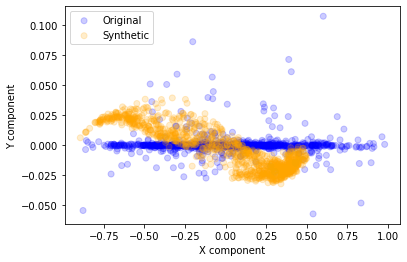

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...
[t-SNE] Computed neighbors for 2000 samples in 0.149s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.014900
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.524734
[t-SNE] KL divergence after 300 iterations: 0.587638


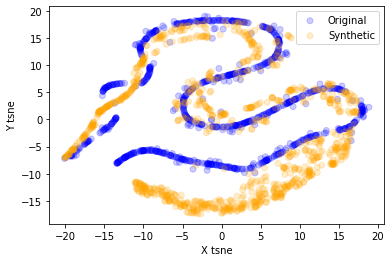

In [ ]:
visualization(ori_data, generated_data, 'pca')
visualization(ori_data, generated_data, 'tsne')

In [ ]:
print(generated_data.shape)

(959975, 24, 5)


In [ ]:
print(generated_data)

[[[0.3636333  0.44564044 0.56880473 0.59031927 0.61848437]
  [0.36670381 0.460567   0.48232585 0.61609065 0.63430082]
  [0.3671731  0.45344499 0.49569851 0.6070395  0.59606653]
  ...
  [0.36549634 0.45205837 0.52999079 0.60010146 0.61384856]
  [0.3653374  0.45213559 0.53036069 0.59966718 0.61394035]
  [0.36517441 0.45221972 0.53069406 0.59926843 0.61402517]]

 [[0.65296382 0.81226569 0.50780951 0.58649629 0.61757122]
  [0.65546536 0.80909193 0.4607709  0.6569516  0.54565387]
  [0.66416293 0.80934417 0.37585422 0.60962164 0.57491218]
  ...
  [0.66384876 0.80298686 0.38443136 0.60400414 0.5062682 ]
  [0.66392898 0.80292916 0.38439726 0.60416936 0.50613176]
  [0.66401374 0.80288506 0.38436049 0.60427027 0.50598996]]

 [[0.13960645 0.75742221 0.52414458 0.59699553 0.60002576]
  [0.14842314 0.76293623 0.42176246 0.61080103 0.64256655]
  [0.15422082 0.75906157 0.48461323 0.56338959 0.57578664]
  ...
  [0.15177792 0.75184071 0.51419287 0.56112545 0.61884563]
  [0.15171766 0.75178742 0.5149772

In [ ]:
print(ori_data[0])

[[0.17241379 0.1075927  0.47345693 0.62135566 0.54985199]
 [0.17241379 0.1075622  0.47284656 0.6217835  0.55133197]
 [0.17241379 0.10753169 0.473579   0.62153902 0.55140987]
 [0.17241379 0.10750214 0.47180895 0.6226392  0.55265617]
 [0.17241379 0.10747163 0.47229724 0.62160014 0.54930674]
 [0.17241379 0.10744112 0.47370107 0.62166126 0.54813833]
 [0.17241379 0.10741157 0.47498283 0.62190574 0.55179934]
 [0.17241379 0.10738106 0.47516594 0.62135566 0.55140987]
 [0.17241379 0.10735055 0.47498283 0.62215023 0.55039725]
 [0.17241379 0.107321   0.47382314 0.62349489 0.54930674]
 [0.17241379 0.10729049 0.4722362  0.62355601 0.55148776]
 [0.17241379 0.10725998 0.47425039 0.62282256 0.5497741 ]
 [0.17241379 0.10723043 0.47534904 0.62233359 0.54767097]
 [0.17241379 0.10719992 0.4757763  0.62074445 0.54954042]
 [0.17241379 0.10716941 0.47614251 0.6214779  0.54992989]
 [0.17241379 0.10713986 0.47675287 0.62471731 0.55133197]
 [0.17241379 0.10710935 0.47693598 0.62447282 0.55211091]
 [0.17241379 0

In [ ]:
print(len(ori_data))

959975


In [ ]:
new_generated_data = generated_data.reshape(-1,5)

In [ ]:
print(new_generated_data[0])

[0.3636333  0.44564044 0.56880473 0.59031927 0.61848437]


In [ ]:
import csv
with open('new_generated_data.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(new_generated_data)
